# 数据介绍

本数据集来自阿里云天池，共有621万条左右数据，数据为淘宝APP2014年11月18日至2014年12月18日的用户行为数据，共计6列字段。

##### 字段解释：
- user_id：用户身份，脱敏
- item_id：商品ID，脱敏
- behavior_type：用户行为类型（包含点击、收藏、加购物车、支付四种行为，分别用数字1、2、3、4表示）
- user_geohash：地理位置
- item_category：品类ID（商品所属的品类）
- time：用户行为发生的时间

##### 分析思维导图：

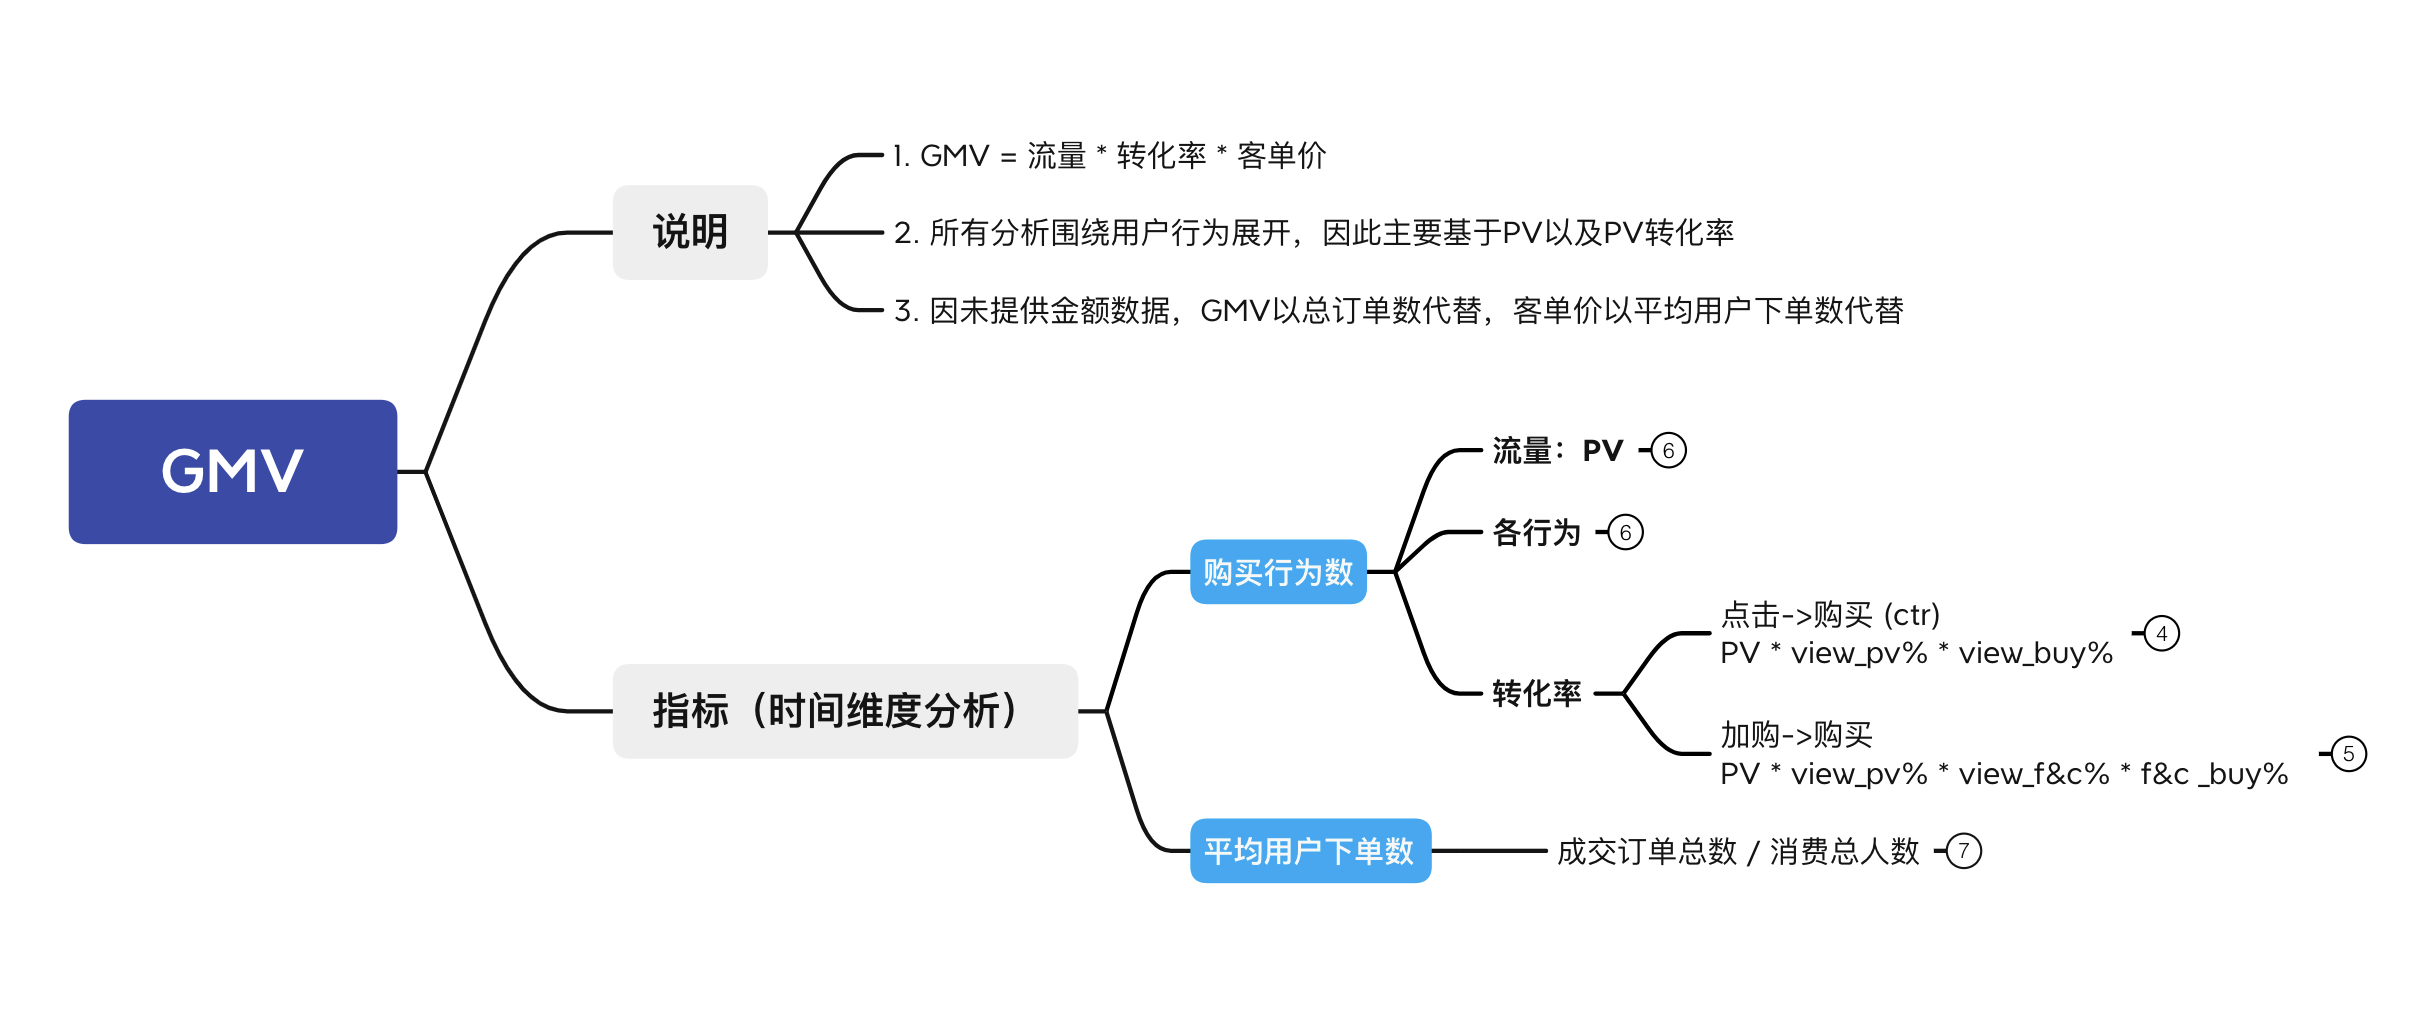

In [80]:
from IPython.display import Image
Image(filename = './Desktop/TB_USER_BEHAVIOR.PNG', width=900)

通过以上角度分析，得出以下结论：
- 日常情况下，淘宝平台成熟，每日用户活跃度（PV,UV）、各环节行为量及转化率、用户平均下单次数都比较稳定；复购率87%，用户忠诚度比较高；
- 双12活下，流量、转化率、购买次数等均有所提高；pv增幅>uv增幅，可见用户量是比较稳定的，活动对流量的提升主要体现在pv上；且在双12，加购行为量上升，收藏量反而下降，可见用户更愿意通过加购来购买商品；


- 在小时维度下，18-24时是用户各行为的高峰期（view, favor, cart成倍增加，buy的增长幅度较小），然而购买转化率高峰期却在10-15时，说明高流量并没有即时带来高购买转化率，推测有一定滞后性；计算“加购->购买”时间差发现绝大部分的情况在1天以内。
- 双12活动下，用户行为分时走势与日常基本一致，只不过将活跃度高峰期延期至次日1点；

# 数据处理

## 数据导入

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyecharts.charts import *
from pyecharts.components import Table
from pyecharts.globals import ThemeType
from pyecharts.options import ComponentTitleOpts
from pyecharts import options as opts

In [82]:
df = pd.read_csv("./Downloads/fresh_comp_offline/tianchi_fresh_comp_train_user.csv")

In [83]:
df.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,10001082,285259775,1,97lk14c,4076,2014-12-08 18
1,10001082,4368907,1,NaN,5503,2014-12-12 12
2,10001082,4368907,1,NaN,5503,2014-12-12 12
3,10001082,53616768,1,NaN,9762,2014-12-02 15
4,10001082,151466952,1,NaN,5232,2014-12-12 11


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23291027 entries, 0 to 23291026
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user_id        int64 
 1   item_id        int64 
 2   behavior_type  int64 
 3   user_geohash   object
 4   item_category  int64 
 5   time           object
dtypes: int64(4), object(2)
memory usage: 1.0+ GB


## 缺失值处理

In [7]:
# 统计各字段缺失数量
df.isnull().sum()

user_id                 0
item_id                 0
behavior_type           0
user_geohash     15911010
item_category           0
time                    0
dtype: int64

In [8]:
# 统计缺失率
df.apply(lambda x: sum(x.isnull())/len(x), axis=0)

user_id          0.000000
item_id          0.000000
behavior_type    0.000000
user_geohash     0.683139
item_category    0.000000
time             0.000000
dtype: float64

缺失情况：除user_geohash外，无缺失。user_geohash暂无分析意义，因此不处理其缺失值。

## 日期格式处理

In [84]:
# 处理 time 的格式，提取出需要的 date 和 hour 数据
df['date'] = df['time'].str[0:10]
df['hour'] = df['time'].str[11:]

In [85]:
# 转换 time, date 为日期数据类型，hour 为整数类型
df['time'] = pd.to_datetime(df['time'])
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['hour'].astype(int)

In [86]:
# 将数据按日期排序，并重建索引
df.sort_values(by='time',ascending=True,inplace=True)
df.reset_index(drop=True,inplace=True)

In [87]:
df.head(5)

,user_id,item_id,behavior_type,user_geohash,item_category,time,date,hour
0,3279691,83408612,1,NaN,5894,2014-11-18,2014-11-18,0
1,107874143,388322409,1,NaN,6549,2014-11-18,2014-11-18,0
2,103995979,148090344,1,NaN,1083,2014-11-18,2014-11-18,0
3,131451821,319468301,1,NaN,3064,2014-11-18,2014-11-18,0
4,107874143,168895154,1,NaN,2883,2014-11-18,2014-11-18,0


# 整体数据分析
- 对于淘宝这种比较成熟的平台来说，日常流量、转化率、用户消费次数等数据是比较稳定的，且复购率比较高，用户忠诚度比较高；

## 宏观分析

In [88]:
# PV：总浏览页面数
total_pv = df['user_id'].count()
# UV：独立访客数
total_uv = df['user_id'].nunique()
# TO：总订单数
total_order = df[df.behavior_type==4].behavior_type.count()
# CTR：所有行为（view+favor+cart）到购买转化率
ctr = df[df.behavior_type==4].count()['user_id'] / df[df.behavior_type !=4].count()['user_id']*100
# 复购率
buy_t  = df[df.behavior_type==4].groupby('user_id').nunique()['date'].reset_index().rename(columns={'date':'buy_time'})
rebuy_rate = buy_t[buy_t.buy_time>=2].count()['user_id'] / buy_t.user_id.count() * 100

In [89]:
#活动期间交易情况的宏观统计表
num_table = Table()
headers = ['指标名称','指标数值']
rows = [
    ['PV：总浏览页面人数',total_pv],
    ['UV：独立访客数',total_uv],
    ['TO：总订单数',total_order],
    ['CTR：所有行为到购买转化率', '{:.2f}%'.format(ctr)],
    ['PV/UV：平均浏览页面数', round(total_pv/total_uv)],
    ['TO/UV：平均用户下单数',round(total_order/total_uv)],
    ['复购率','{:.2f}%'.format(rebuy_rate)]
]
num_table.add(headers, rows)
num_table.set_global_opts(
    title_opts=ComponentTitleOpts(title='商品销售的宏观状况')
)
num_table.render_notebook()

指标名称,指标数值
PV：总浏览页面人数,23291027
UV：独立访客数,20000
TO：总订单数,232579
CTR：所有行为到购买转化率,1.01%
PV/UV：平均浏览页面数,1165
TO/UV：平均用户下单数,12
复购率,87.02%


## 用户行为分析

##### 总结
- 每日
    - PV, UV: 淘宝平台成熟，用户量稳定，只有在像双12这样大型购物活动，才会看到流量明显提升，且活动对流量的提升主要体现在PV上；
    - 用户平均每100次操作（view+favor+cart），会有一次购买行为；
    - 转化方面，用户更愿意通过加购进行购买；
    - 用户复购率高达87.2%，在平台上的用户具有较高的忠诚度，可能平台的消费主力是常年积累的忠实用户，而不是通过推广、用户分享等途径的加入的新用户。
    

- 分时
    - PV, UV: 用户最活跃的时间段为18-24时；虽然在这一时间段，view, favor, cart成倍增加，但是buy的增长幅度却较小；说明高流量并没有即时带来高转化率（推测有一定滞后性）：
    - 与日CTR一致，每100次操作会有1次购买；
    - 转化率高峰基本在10-15点之间，而非用户活跃期18-24点；证实了之前所说的高流量并没有即时带来高转化率。

### PV, UV

##### 每日情况

In [90]:
# 每日PV
pv_daily = df.groupby('date').count()['user_id']
# 每日UV
uv_daily = df.groupby('date')['user_id'].apply(lambda x: x.drop_duplicates().count())
# 整合 pv, uv 数据
pv_uv = pd.concat([pv_daily, uv_daily], axis=1)
pv_uv.columns=['pv','uv']

In [91]:
# pv, uv 统计数据
pv_uv.describe()

,pv,uv
count,3.100000e+01,31.000000
mean,7.513235e+05,12858.935484
std,1.241402e+05,595.412850
min,6.341220e+05,12163.000000
25%,6.886915e+05,12529.500000
50%,7.345200e+05,12802.000000
75%,7.637915e+05,13009.500000
max,1.344980e+06,15314.000000


Text(0.5, 1.0, 'uv_daily')

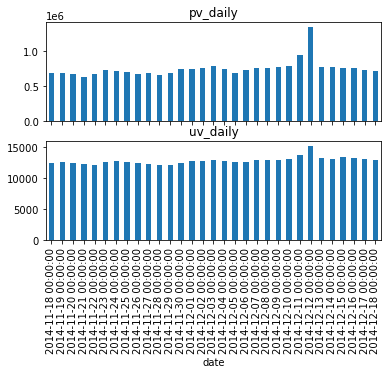

In [92]:
# pv, uv 可视化
fig,axes=plt.subplots(2,1,sharex=True)
pv_daily.plot(kind='bar',x='date',y='pv',ax=axes[0])
uv_daily.plot(kind='bar',x='date',y='uv',ax=axes[1])
axes[0].set_title('pv_daily')
axes[1].set_title('uv_daily')

In [93]:
print('平均每日pv量：', round(pv_daily.mean()/10000),'万次')
print('最高每日pv量：', round(pv_daily.max()/10000),'万次')
print('双12 pv增幅：', '{:}%'.format(round(pv_daily.max()/pv_daily.mean()*100)))
print('平均每日uv量：', round(uv_daily.mean()),'人')
print('最高每日uv量：', round(uv_daily.max()),'人')
print('双12 uv增幅：', '{:}%'.format(round(uv_daily.max()/uv_daily.mean()*100)))
print('平均用户活跃度：', '{:.0f}%'.format(uv_daily.mean()/total_uv*100))
print('最高用户活跃度：', '{:.0f}%'.format(uv_daily.max()/total_uv*100))

平均每日pv量： 75 万次
最高每日pv量： 134 万次
双12 pv增幅： 179%
平均每日uv量： 12859 人
最高每日uv量： 15314 人
双12 uv增幅： 119%
平均用户活跃度： 64%
最高用户活跃度： 77%


##### 每小时情况

In [94]:
# 分时 pv, uv
pv_hour = df.groupby('hour').count()['user_id']
uv_hour=df.groupby('hour').nunique()['user_id']
# 整合 pv, uv 数据
pv_uv_hour = pd.concat([pv_hour, uv_hour],axis=1)
pv_uv_hour.columns = ['pv','uv']

In [95]:
# pv, uv 统计数据
pv_uv_hour.describe()

,pv,uv
count,2.400000e+01,24.000000
mean,9.704595e+05,13016.916667
std,5.620187e+05,5039.336282
min,1.410000e+05,3314.000000
25%,5.121262e+05,10198.500000
50%,1.026198e+06,16141.000000
75%,1.144271e+06,16350.500000
max,2.106305e+06,17547.000000


Text(0.5, 1.0, 'uv_hour')

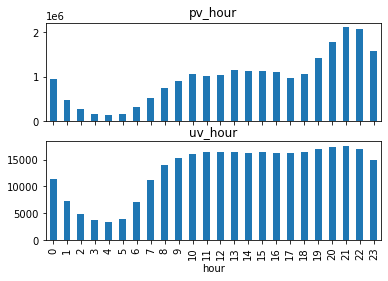

In [96]:
# pv, uv 可视化
fig,axes=plt.subplots(2,1,sharex=True)
pv_hour.plot(kind='bar',x='date',y='pv',ax=axes[0])
uv_hour.plot(kind='bar',x='date',y='uv',ax=axes[1])
axes[0].set_title('pv_hour')
axes[1].set_title('uv_hour')

### 各行为访问量
- 各行为走势大体相同，均在双12达到峰值；
- 与收藏和购买相比，加购和购买走势关联更强；因此接下来着重关注加购->购买转化；


- 在小时维度下，18时-24时用户各行为次数也大幅增加，与前面pv,uv一致。



##### 每日

In [97]:
# 基于PV - 1：点击，2：收藏，3：加购物车，4：购买
daily = pd.pivot_table(columns='behavior_type',
                        index='date',
                        data=df,
                        values='user_id',
                        aggfunc=np.size,)
daily.columns = ['view','favor','cart','buy'] 
daily.head()

,view,favor,cart,buy
date,,,,
2014-11-18,644879,13425,19591,6733
2014-11-19,648708,13683,18808,6329
2014-11-20,634039,13286,18586,6278
2014-11-21,596847,12797,18229,6249
2014-11-22,630885,13236,18105,6283


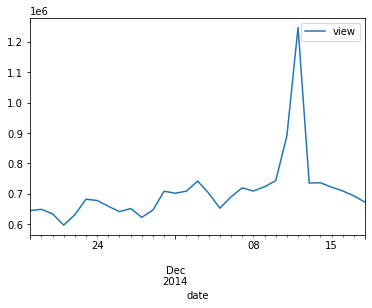

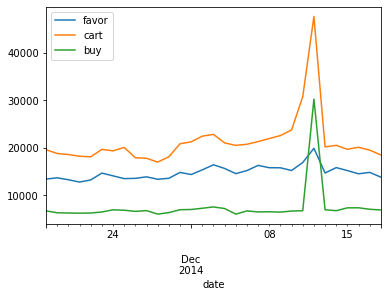

In [98]:
# 可视化
daily.iloc[:,:1].plot(kind='line')
daily.iloc[:,1:].plot(kind='line')

plt.show()

##### 分时

In [99]:
hour = pd.pivot_table(columns='behavior_type',
                        index='hour',
                        data=df,
                        values='user_id',
                        aggfunc=np.size,)
hour.columns = ['view','favor','cart','buy'] 

In [ ]:
plt.figure(figsize=(10,5))
hour.iloc[:,:1].plot(kind='bar')
hour.iloc[:,1:4].plot(kind='bar')

plt.show()

### 转化率

小结：
- 从CTR看，用户平均每100次操作（view+favor+cart），才会有一次购买行为。
- 转化率高峰均在双12
- 从趋势来看：转化率高峰均在双12；且在双12，加购上升，收藏反而下降，可见用户更愿意通过加购来购买商品
- 从点击-加入购物车-购买转化看：点击到加购的转化率只有3%，加购到购买转化有21%，说明用户只要能加购，就有21%的概率可以购买

##### 每日

In [100]:
# CTR
daily['ctr'] = daily['buy'] / (daily['view'] + daily['favor'] + daily['cart'])
# pv-点击转化率
daily['pv_view'] = daily['view'] / pv_daily
# 点击-加购转化率
daily['view_cart'] = daily['cart'] / daily['view']
# 点击-购买转化率
daily['view_buy'] = daily['buy'] / daily['view']
# 点击-收藏转化率
daily['view_favor'] = daily['favor'] / daily['view']
# 收藏-购买转化率
daily['favor_buy'] = daily['buy'] / daily['favor']
# 加购-购买转化率
daily['cart_buy'] = daily['buy'] / daily['cart']
# 收藏&加入购物车-购买转化率
daily['f&v_buy'] = daily['buy'] / (daily['favor']+daily['cart'])

In [101]:
#所有转化率
daily.iloc[:,4:].head()

,ctr,pv_view,view_cart,view_buy,view_favor,favor_buy,cart_buy,f&v_buy
date,,,,,,,,
2014-11-18,0.009932,0.941941,0.030379,0.010441,0.020818,0.501527,0.343678,0.203931
2014-11-19,0.009291,0.943537,0.028993,0.009756,0.021093,0.462545,0.336506,0.194792
2014-11-20,0.009428,0.943245,0.029314,0.009902,0.020955,0.472527,0.337781,0.196975
2014-11-21,0.009953,0.941218,0.030542,0.010470,0.021441,0.488318,0.342805,0.201412
2014-11-22,0.009488,0.943720,0.028698,0.009959,0.020980,0.474690,0.347031,0.200472


In [102]:
daily.iloc[:,4:].describe()

,ctr,pv_view,view_cart,view_buy,view_favor,favor_buy,cart_buy,f&v_buy
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.009779,0.942428,0.029780,0.010277,0.021044,0.496986,0.343918,0.202083
std,0.002526,0.003172,0.002305,0.002666,0.001219,0.192388,0.063223,0.048359
min,0.007217,0.927302,0.027280,0.007603,0.015955,0.399460,0.220066,0.142030
25%,0.009056,0.941679,0.028088,0.009499,0.020679,0.442101,0.327118,0.187998
50%,0.009488,0.943220,0.029431,0.009959,0.021093,0.472527,0.342066,0.197098
75%,0.009807,0.943983,0.030652,0.010298,0.021602,0.488311,0.357746,0.205155
max,0.022998,0.946123,0.038198,0.024244,0.022661,1.519524,0.634684,0.447690


<AxesSubplot:xlabel='date'>

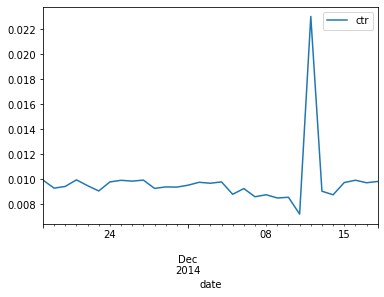

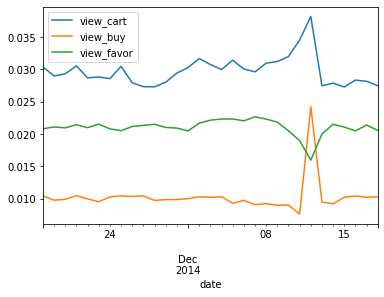

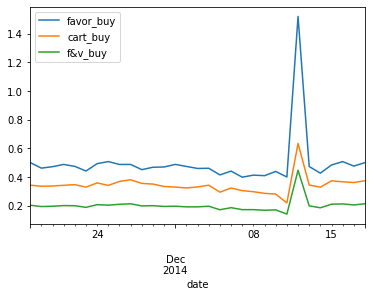

In [103]:
# 趋势
daily.iloc[:,4:5].plot()
daily.iloc[:,6:9].plot()
daily.iloc[:,9:].plot()

In [104]:
# 点击-收藏&加入购物车-购买转化
table1 = Table()
headers = ['环节','人数','转化率']
rows = [
    ['pv',total_pv,total_pv/total_pv],
    ['view',daily['view'].sum(),round(daily['view'].sum()/total_pv,2)],
    ['favor&cart',daily['favor'].sum()+daily['cart'].sum(),round((daily['favor'].sum()+daily['cart'].sum())/daily['view'].sum(),2)],
    ['buy',daily['buy'].sum(),round(daily['buy'].sum()/(daily['favor']+daily['cart']).sum(),2)],

]
table1.add(headers, rows)
table1.set_global_opts(
    title_opts=ComponentTitleOpts(title='点击-收藏&加入购物车-购买转化')
)
table1.render_notebook()

环节,人数,转化率
pv,23291027,1.0
view,21940520,0.94
favor&cart,1117928,0.05
buy,232579,0.21


##### 分时

In [105]:
# CTR
hour['ctr'] = hour['buy'] / (hour['view'] + hour['favor'] + hour['cart'])
# pv-点击转化率
hour['pv_view'] = hour['view'] / pv_hour
# 点击-加购转化率
hour['view_cart'] = hour['cart'] / hour['view']
# 点击-购买转化率
hour['view_buy'] = hour['buy'] / hour['view']
# 点击-收藏转化率
hour['view_favor'] = hour['favor'] / hour['view']
# 收藏-购买转化率
hour['favor_buy'] = hour['buy'] / hour['favor']
# 加购-购买转化率
hour['cart_buy'] = hour['buy'] / hour['cart']
# 收藏&加入购物车-购买转化率
hour['f&c_buy'] = hour['buy'] / (hour['favor'] + hour['cart'])

In [106]:
hour.iloc[:,4:].describe()

,ctr,pv_view,view_cart,view_buy,view_favor,favor_buy,cart_buy,f&c_buy
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,0.009454,0.942560,0.029450,0.009937,0.021567,0.467401,0.334811,0.194591
std,0.002853,0.003458,0.001963,0.003004,0.001535,0.153965,0.089342,0.057001
min,0.005139,0.936885,0.026163,0.005406,0.018927,0.230312,0.188938,0.103792
25%,0.006870,0.939197,0.028132,0.007221,0.020709,0.306560,0.254135,0.141615
50%,0.009024,0.944074,0.029598,0.009462,0.021389,0.479561,0.339869,0.194803
75%,0.012417,0.945205,0.030837,0.013062,0.022233,0.627171,0.419218,0.251262
max,0.013676,0.947599,0.034210,0.014396,0.025365,0.679992,0.457208,0.273389


<AxesSubplot:xlabel='hour'>

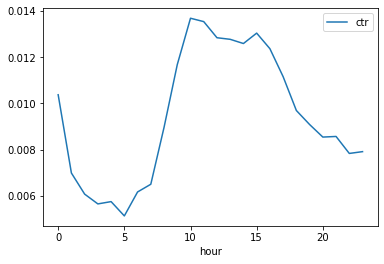

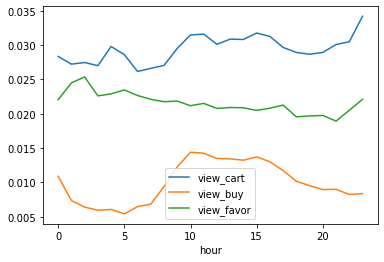

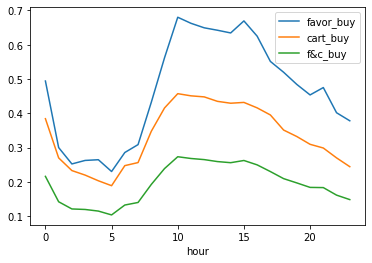

In [107]:
# 趋势
hour.iloc[:,4:5].plot()
hour.iloc[:,6:9].plot()
hour.iloc[:,9:].plot()

## 用户付费情况分析

### 每日平均消费次数
- 用户平均消费次数为2.3次，双12人均消费次数增至3.9次
- 从用户消费次数分布看，消费2次的用户最多，50%以上的用户消费10次以内。

In [108]:
# 每日成交订单总数
daily_buy = daily['buy']
# 每日消费总人数
daily_user = df[df.behavior_type==4].groupby('date').nunique()['user_id']
# 用户平均消费次数
aveg_buy = daily_buy / daily_user

In [109]:
aveg_buy.describe()

count    31.000000
mean      2.334564
std       0.311074
min       2.139675
25%       2.244665
50%       2.288992
75%       2.328009
max       3.976460
dtype: float64

<AxesSubplot:xlabel='date'>

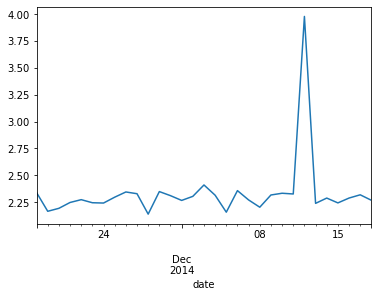

In [110]:
aveg_buy.plot()

In [111]:
# 用户消费次数分布情况
user_time = df[df.behavior_type==4].groupby('user_id').count()['item_id'].reset_index().rename(columns={'item_id':'buy_time'})
user_buy = user_time.groupby('buy_time').count()['user_id']

In [112]:
buy_num = (
    Bar()
    .add_xaxis(user_buy.index.tolist())
    .add_yaxis("",user_buy.values.tolist(),label_opts=opts.LabelOpts(is_show=False))
    .set_global_opts(xaxis_opts=opts.AxisOpts(min_=0, max_=100)
        ,title_opts=opts.TitleOpts(title="用户消费次数分布情况"))
)
buy_num.render_notebook()

### 每时平均消费次数
- 平均每小时消费次数为2.46次，从活跃度最高的12点和21点消费次数分布来看，绝大部分用户消费2次及以内；
- 消费次数最高峰出现在0点，推测是因为受双12影响，在0点凑单消费；

In [113]:
# 每时成交订单总数
hour_buy = hour['buy']
# 每时消费总人数
hour_user = df[df.behavior_type==4].groupby('hour').nunique()['user_id']
# 用户平均消费次数
aveg_buyh = hour_buy / hour_user

In [114]:
aveg_buyh.describe()

count    24.000000
mean      2.463463
std       0.244689
min       2.001179
25%       2.333610
50%       2.470131
75%       2.611158
max       3.060979
dtype: float64

In [ ]:
aveg_buyh.plot(secondary_y=True,color='#C7518F')
hour_buy.plot(kind='bar',color='#70DFDF')
hour_user.plot(kind='bar',color='#6980C5')

In [115]:
# 用户消费次数分布情况
userh_time = df[df.behavior_type==4].groupby(
    ['hour','user_id']).count()['item_id'].reset_index().rename(columns={'item_id':'buyh_time'})

<AxesSubplot:xlabel='buyh_time'>

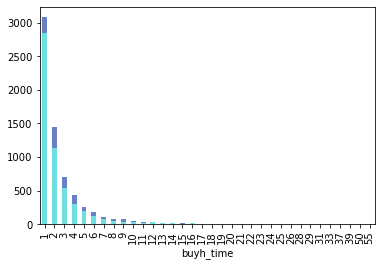

In [116]:
# 选择用户活跃度最高的12点和21点查看分布情况
userh_time[userh_time.hour==21].groupby('buyh_time').count()['user_id'].plot(kind='bar',color='#6980C5')
userh_time[userh_time.hour==12].groupby('buyh_time').count()['user_id'].plot(kind='bar',color='#70DFDF')

### 加购->购买时间差
- 绝大部分的的“加购->购买”时间差在1天以内。

In [117]:
df_ = pd.concat([df.iloc[:,:3],df.iloc[:,5:6]], axis=1)
df_3 = df_[df_['behavior_type'] == 3].rename(columns={'behavior_type':'bt3','time':'t3'})
df_4 = df_[df_['behavior_type'] == 4].rename(columns={'behavior_type':'bt4','time':'t4'})
df_34 = pd.merge(df_3, df_4, on=['user_id','item_id'], how='inner')
df_34 = df_34[df_34.t4 > df_34.t3]

In [118]:
df_34.drop_duplicates(inplace=True)
df_34.reset_index(drop=True, inplace=True)

In [119]:
df_34['diff'] = ((df_34['t4'] - df_34['t3']).astype('timedelta64[h]'))

In [120]:
df_34.describe()

,user_id,item_id,bt3,bt4,diff
count,5.851200e+04,5.851200e+04,58512.0,58512.0,58512.000000
mean,7.022405e+07,2.022835e+08,3.0,4.0,66.414001
std,4.565043e+07,1.165972e+08,0.0,0.0,104.093938
min,4.920000e+02,1.096600e+04,3.0,4.0,1.000000
25%,3.096529e+07,1.021260e+08,3.0,4.0,5.000000
50%,5.629630e+07,2.021952e+08,3.0,4.0,22.000000
75%,1.168390e+08,3.028140e+08,3.0,4.0,78.000000
max,1.424275e+08,4.045594e+08,3.0,4.0,741.000000


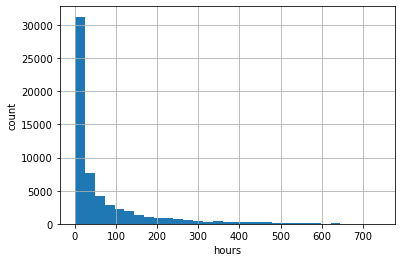

In [121]:
plt.hist(df_34['diff'],bins=31)
plt.xlabel('hours')
plt.ylabel('count')
plt.grid()
plt.show()

## 商品信息分析
- 用户最高购买次数的商品只被购买了50次，说明平台的商品竞争较为激烈，并没有特别突出的“爆款”商品。
- 用户对品类为“1863”、‘6513’、‘5232’、‘6344’的需求较高，这几类商品可能是必需品，需要根据具体数据进一步分析。

### TOP10 商品类目

In [122]:
category = df.groupby('item_category')
category = category.behavior_type.value_counts().unstack()

In [123]:
category.head()

behavior_type,1,2,3,4
item_category,,,,
2,11.0,NaN,NaN,NaN
6,1.0,NaN,NaN,NaN
8,1864.0,7.0,26.0,13.0
10,220.0,1.0,4.0,1.0
11,17174.0,251.0,143.0,20.0


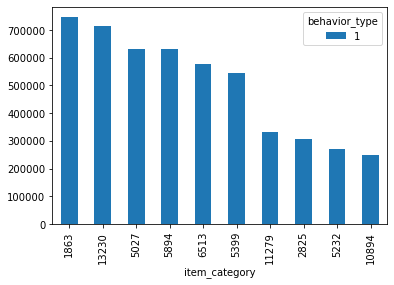

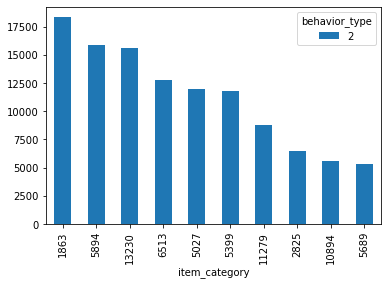

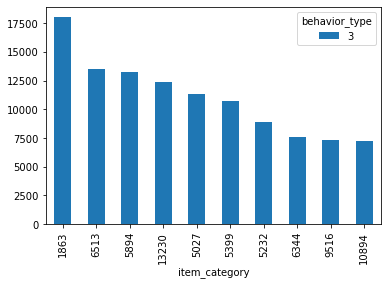

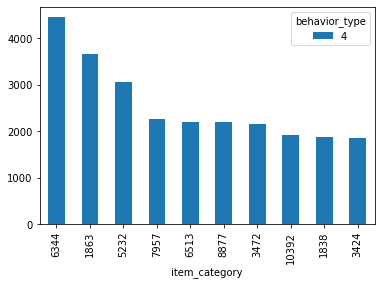

In [124]:
# 点击类目TOP10
view10_category = category.sort_values(by=1,ascending=False).iloc[:10,0:1].plot(kind='bar')
# 收藏类目TOP10
favor10_category = category.sort_values(by=2,ascending=False).iloc[:10,1:2].plot(kind='bar')
# 加购类目TOP10
cart10_category = category.sort_values(by=3,ascending=False).iloc[:10,2:3].plot(kind='bar')
# 热销类目TOP10
buy10_category = category.sort_values(by=4,ascending=False).iloc[:10,3:].plot(kind='bar')

### TOP10 商品

In [125]:
good = df.groupby('item_id')
good = good.behavior_type.value_counts().unstack()

In [126]:
good.head()

behavior_type,1,2,3,4
item_id,,,,
37,13.0,NaN,1.0,3.0
64,7.0,NaN,1.0,NaN
177,1.0,NaN,NaN,NaN
270,1.0,NaN,NaN,NaN
368,2.0,NaN,NaN,NaN


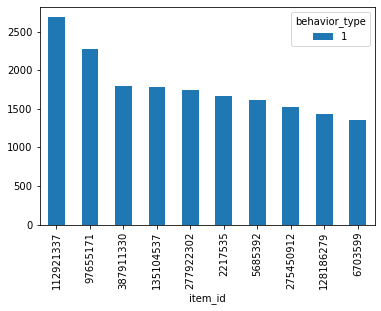

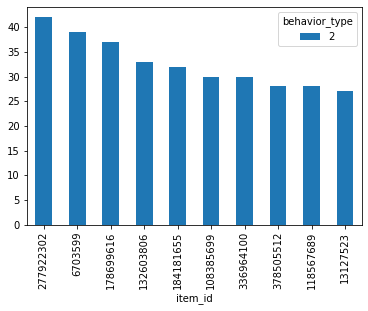

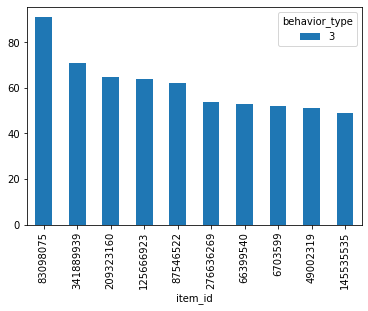

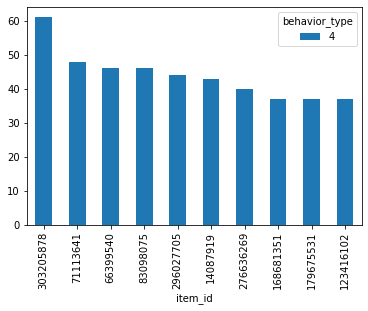

In [127]:
# 点击商品TOP10
view10_good = good.sort_values(by=1,ascending=False).iloc[:10,0:1].plot(kind='bar')
# 收藏商品TOP10
favor10_good = good.sort_values(by=2,ascending=False).iloc[:10,1:2].plot(kind='bar')
# 加购商品TOP10
cart10_good = good.sort_values(by=3,ascending=False).iloc[:10,2:3].plot(kind='bar')
# 热销商品TOP10
buy10_good = good.sort_values(by=4,ascending=False).iloc[:10,3:].plot(kind='bar')

# 活动当天分析

In [128]:
# 活动期
df_event = df[df['date'] == '2014-12-12'] 

## PV, UV & 各行为

In [129]:
pv_event = df_event.groupby('hour').count()['user_id']
uv_event = df_event.groupby('hour').nunique()['user_id']
view_event = df_event[df_event.behavior_type==1].groupby('hour').count()['user_id']
favor_event = df_event[df_event.behavior_type==2].groupby('hour').count()['user_id']
cart_event = df_event[df_event.behavior_type==3].groupby('hour').count()['user_id']
buy_event = df_event[df_event.behavior_type==4].groupby('hour').count()['user_id']

<AxesSubplot:xlabel='hour', ylabel='buy'>

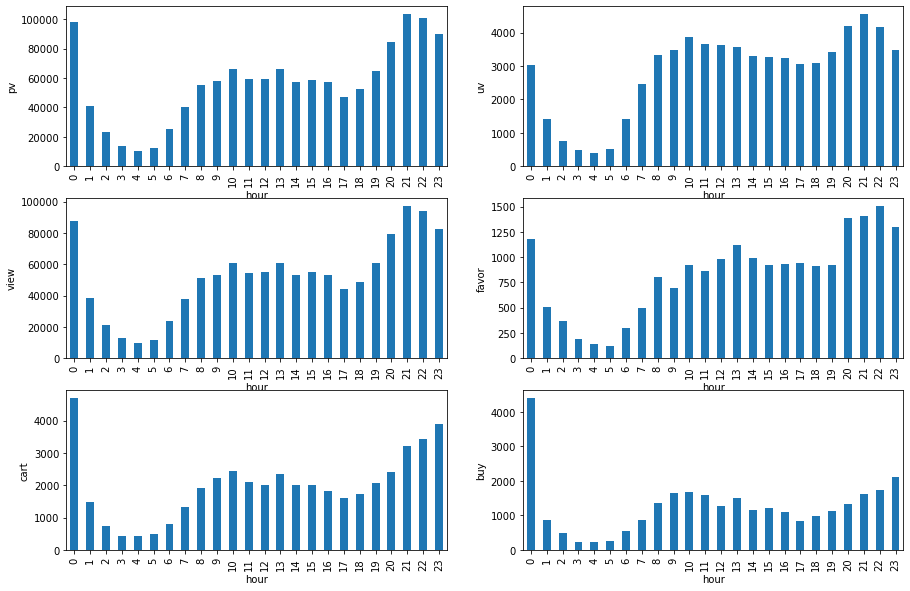

In [130]:
plt.figure(figsize=(15,10))
plt.subplot(3,2,1)
pv_event.plot(kind='bar',ylabel='pv')
plt.subplot(3,2,2)
uv_event.plot(kind='bar',ylabel='uv')
plt.subplot(3,2,3)
view_event.plot(kind='bar',ylabel='view')
plt.subplot(3,2,4)
favor_event.plot(kind='bar',ylabel='favor')
plt.subplot(3,2,5)
cart_event.plot(kind='bar',ylabel='cart')
plt.subplot(3,2,6)
buy_event.plot(kind='bar',ylabel='buy')

## 转化率

In [131]:
# CTR
ctr_event = buy_event.sum() / (view_event+favor_event+cart_event).sum() * 100
# pv-点击转化率
pv_view_event = view_event.sum() / pv_event.sum() * 100
# 点击-加购转化率
vc_event = cart_event.sum() / view_event.sum() * 100
# 点击-购买转化率
vb_event = buy_event.sum() / view_event.sum() * 100
# 点击-收藏转化率
vf_event = favor_event.sum() / view_event.sum() * 100
# 收藏-购买转化率
fb_event = buy_event.sum() / favor_event.sum() * 100
# 加购-购买转化率
cb_event = buy_event.sum() / cart_event.sum() * 100
# 收藏&加入购物车-购买转化率
fc_buy_event = buy_event.sum() / (favor_event.sum()+cart_event.sum()) * 100

In [132]:
# 转化率情况表
e_table = Table()
headers = ['环节','转化率']
rows = [
    ['CTR', '{:.2f}%'.format(ctr_event)],
    ['PV->点击', '{:.2f}%'.format(pv_view_event)],
    ['点击->收藏', '{:.2f}%'.format(vf_event)],
    ['点击->加购', '{:.2f}%'.format(vc_event)],
    ['点击->购买', '{:.2f}%'.format(vb_event)],
    ['收藏->购买', '{:.2f}%'.format(vb_event)],
    ['加购->购买','{:.2f}%'.format(cb_event)],
    ['收藏&加购->购买', '{:.2f}%'.format(fc_buy_event)]
]
e_table.add(headers, rows)
e_table.set_global_opts(
    title_opts=ComponentTitleOpts(title='转化率情况表')
)
e_table.render_notebook()

环节,转化率
CTR,2.30%
PV->点击,92.73%
点击->收藏,1.60%
点击->加购,3.82%
点击->购买,2.42%
收藏->购买,2.42%
加购->购买,63.47%
收藏&加购->购买,44.77%


## 平均用户下单数

In [133]:
# 消费总人数
pu_event = df_event[df_event.behavior_type==4].groupby('hour').nunique()['user_id']
# 用户平均消费次数
freq_event = buy_event / pu_event

In [134]:
freq_event.describe()

count    24.000000
mean      2.148099
std       0.366989
min       1.743758
25%       1.924231
50%       1.982473
75%       2.342537
max       3.343703
Name: user_id, dtype: float64

<AxesSubplot:xlabel='hour'>

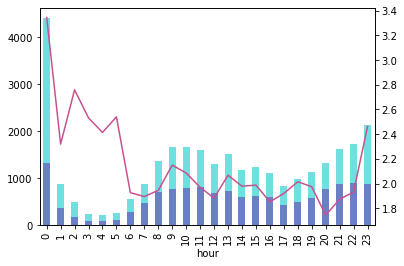

In [135]:
freq_event.plot(secondary_y=True,color='#C7518F')
buy_event.plot(kind='bar',color='#70DFDF')
pu_event.plot(kind='bar',color='#6980C5')

In [136]:
# 用户消费次数分布情况
time_event = df_event[df_event.behavior_type==4].groupby(
    'user_id').count()['item_id'].reset_index().rename(columns={'item_id':'buy_time'})

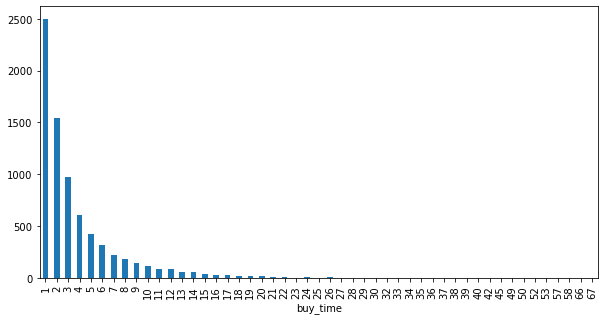

In [137]:
plt.figure(figsize=(10,5))
time_event.groupby('buy_time').count()['user_id'].plot(kind='bar')
plt.show()

# RFM 模型分析用户价值

- RFM 模型是衡量客户价值和客户创利能力的重要工具和手段，其中由3个要素构成了数据分析最好的指标，分别是：
    - R-Recency（最近一次购买时间），R值越高，一般说明用户比较活跃；
    - F-Frequency（消费频率），F值越高，说明用户越忠诚；
    - M-Money（消费金额），M值越高，说明用户消费能力越好

- 由于本数据集没有消费金额数据，故只针对RF维度进行分析。

In [138]:
# Recency
last_time = df[df.behavior_type==4].groupby('user_id').max()['date']
recency = (pd.to_datetime('2014-12-11')-last_time)
recency = recency.reset_index().rename(columns={'date':'recency'})
recency.head()

,user_id,recency
0,492,-3 days
1,3726,1 days
2,36465,16 days
3,37101,0 days
4,38745,15 days


In [139]:
# Frequency
freq = df[df.behavior_type==4].groupby('user_id').date.count()
freq = freq.reset_index().rename(columns={'date':'freq'})
freq.head(5)

,user_id,freq
0,492,5
1,3726,4
2,36465,1
3,37101,3
4,38745,4


In [140]:
# RFM
rfm = pd.merge(recency, freq, left_on='user_id', right_on='user_id')

# 赋值
rfm['recency_value'] = pd.qcut(rfm.recency, 2, labels=['n','y'])
rfm['freq_value'] = pd.qcut(rfm.freq, 2, labels=['n','y'])
rfm['type'] = rfm["recency_value"].str.cat(rfm["freq_value"])

rfm.head()

,user_id,recency,freq,recency_value,freq_value,type
0,492,-3 days,5,n,n,nn
1,3726,1 days,4,y,n,yn
2,36465,16 days,1,y,n,yn
3,37101,0 days,3,y,n,yn
4,38745,15 days,4,y,n,yn


In [141]:
rfm.groupby('type').count()['recency'].rename(
    index={'yy':'重要价值用户：','yn':'重要发展用户：','ny':'重要保持用户：','nn':'重要挽留用户：'})

type
重要挽留用户：    3355
重要保持用户：    6198
重要发展用户：    5751
重要价值用户：    2350
Name: recency, dtype: int64

小结：
- 重要价值用户是最优质的用户群体，应重点关注，既要保持其粘性，又要继续引导消费，可为这类用户提供vip服务；
- 重要发展用户的特点是近期有消费但频次不高，策略是提高其消费次数，具体措施有促销活动提醒和优惠卷活动等；
- 重要保持用户的特点是消费频次高但有一段时间没有消费，策略是重新唤醒，通过app消息推送，以及站外广告营销吸引其注意力，促进复购；
- 重要挽留用户近期没有消费且频次不高，若不加以挽留，会有流失的可能，对于这类用户一方面需要保持曝光量，持续推送活动和优惠信息，另一方面需要进一步研究其兴趣和需求，才能采取有效的运营策略。